# Lab 3: Building a Travel Planner with a Simple LangGraph

## Overview

This lab guides you through the process of creating a simple Travel Planner using LangGraph, a library for building stateful, multi-step applications with language models. The Travel Planner demonstrates how to structure a conversational AI application that collects user input and generates personalized travel itineraries.

## Intro to Agents
- Agents are leverage LLM to `think step by step` and then plan the execution
- Agents have access to tools
- Agents have access to memory. Below diagram illustrates this concept

#### Memory Management
Memory is key for any agentic conversation which is `Multi-Turn` or `Multi-Agent` colloboration conversation and more so if it spans multiple days. The 3 main aspects of Agents are:
1. Tools
2. Memory
3. Planners

- ![Agent memory](./images/agents_memory_light.png)

## Use Case Details

Our Travel Planner follows a straightforward, three-step process:

1. **Initial User Input**: 
   - The application prompts the user to enter their desired travel plan to get assistance from AI Agent.
   - This information is stored in the state.

2. **Interests Input**:
   - The user is asked to provide their interests for the trip.
   - These interests are stored as a list in the state.

3. **Itinerary Creation**:
   - Using the collected city and interests, the application leverages a language model to generate a personalized day trip itinerary.
   - The generated itinerary is presented to the user.

The flow between these steps is managed by LangGraph, which handles the state transitions and ensures that each step is executed in the correct order.

The below diagram illustrates this:

![Travel Planner Agent](./images/agents_itinerary.png)

In [ ]:

# %pip install -U --no-cache-dir  \
# langchain>=0.3.7 \ 
# langchain-anthropic>=0.1.15 \
# langchain-aws>=0.2.6 \
# langchain-community>=0.3.5 \
# langchain-core>=0.3.15 \
# langchain-text-splitters>=0.3.2 \
# langchainhub>=0.1.20 \
# langgraph>=0.2.45 \
# langgraph-checkpoint>=2.0.2 \
# langgraph-sdk>=0.1.35 \
# langsmith>=0.1.140 \
# sqlalchemy -U \
# "faiss-cpu>=1.7,<2" \
# "pypdf>=3.8,<4" \
# "ipywidgets>=7,<8" \
# matplotlib>=3.9.0 \

#%pip install -U --no-cache-dir transformers
#%pip install -U --no-cache-dir boto3
#%pip install grandalf==3.1.2

### Setup and Imports

First, let's import the necessary modules and set up our environment.

In [2]:
import os
from typing import TypedDict, Annotated, List
from langgraph.graph import StateGraph, END
from langchain_core.messages import HumanMessage, AIMessage
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables.graph import MermaidDrawMethod
from IPython.display import display, Image
from dotenv import load_dotenv
import os
#load_dotenv()

## LangGraph -- State Graph, Nodes and Edges

First, we are initializing the ```StateGraph```. This object will encapsulate the graph being traversed during excecution.

Then we define the **nodes** in our graph. In LangGraph, nodes are typically python functions. There are two main nodes we will use for our graph:
- The agent node: responsible for deciding what (if any) actions to take.
- The tool node: This node will orchestrate calling the respective tool and returning the output. This means if the agent decides to take an action, this node will then execute that action.

**Edges** define how the logic is routed and how the graph decides to stop. This is a big part of how your agents work and how different nodes communicate with each other. There are a few key types of edges:

- Normal Edges: Go directly from one node to the next.
- Conditional Edges: Call a function to determine which node(s) to go to next.
- Entry Point: Which node to call first when user input arrives.
- Conditional Entry Point: Call a function to determine which node(s) to call first when user input arrives.

In our case we need to define a conditional edge that routes to the ```ToolNode``` when a tool get called in the agent node, i.e. when the LLM determines the requirement of tool use. With ```tools_condition```, LangGraph provides a preimplemented function handling this. Further, an edge from the ```START```node to the ```assistant```and from the ```ToolNode``` back to the ```assistant``` are required.

We are adding the nodes, edges as well as a persistant memory to the ```StateGraph``` before we compile it. 

### Define Agent State

We'll define the state that our agent will maintain throughout its operation. First, define the [State](https://langchain-ai.github.io/langgraph/concepts/low_level/#state) of the graph.  The State schema serves as the input schema for all Nodes and Edges in the graph.

Let's use the `TypedDict` class from python's `typing` module as our schema, which provides type hints for the keys.

### Key Components

1. **StateGraph**: The core of our application, defining the flow of our Travel Planner.
2. **PlannerState**: A custom type representing the state of our planning process.
3. **Node Functions**: Individual steps in our planning process (input_city, input_interests, create_itinerary).
4. **LLM Integration**: Utilizing a language model to generate the final itinerary.
5. **Memory Integration**: Utilizing long term and short term memory for conversations

#### Advanced concepts

Now we'll define the main functions nodes that our agent will use: get interests, create itinerary. 

- [Nodes](https://langchain-ai.github.io/langgraph/concepts/low_level/#nodes) are python functions.
- The first positional argument is the state, as defined above. 
- State is a `TypedDict` with schema as defined above, each node can access the key, `graph_state`, with `state['graph_state']`. 
- Each node returns a new value of the state key `graph_state`.
  
By default, the new value returned by each node [will override](https://langchain-ai.github.io/langgraph/concepts/low_level/#reducers) the prior state value.

### Memory

1. We will disscuss memory is detail in subsequent sections below how some some key points
2. We have `Conversational Memory` which is needed for all agents to have context since this is a `ChatBot` which needs history of conversations
3. We usually summarize these into a **Summary Conversation** alternating with Human | AI for multi session conversations
4. We have the concept of Graph State which is for Async workflows where we need to resume the workflow from a **certain point** in history

For `A-Sync` workflows where we need to persist the state of the graph and bring it back once we get the required data. below diagram explains this concept. 


<img src="./images/graph_state_light.png" width="45%"/>


### Define Agent Nodes

we will create a simple graph with 
- user travel plans
- invoke with Bedrock
- generate the travel plan for the day 
- ability to add or modify the plan

In [3]:
class PlannerState(TypedDict):
    messages: Annotated[List[HumanMessage | AIMessage], "The messages in the conversation"]
    itinerary: str
    city: str
    user_message: str

### Set Up Language Model and Prompts


In [4]:
#llm = ChatOpenAI(model="gpt-4o-mini")

from langchain_aws import ChatBedrockConverse
from langchain_aws import ChatBedrock
import boto3
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.runnables.config import RunnableConfig
from langchain_core.chat_history import InMemoryChatMessageHistory
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables.history import RunnableWithMessageHistory
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

# ---- ⚠️ Update region for your AWS setup ⚠️ ----
bedrock_client = boto3.client("bedrock-runtime", region_name="us-east-1")
model_id = "anthropic.claude-3-haiku-20240307-v1:0"
#model_id = "anthropic.claude-3-sonnet-20240229-v1:0"#
#model_id="anthropic.claude-3-5-sonnet-20240620-v1:0"

provider_id = "anthropic"

llm = ChatBedrockConverse(
    model=model_id,
    provider=provider_id,
    temperature=0,
    max_tokens=None,
    client=bedrock_client,
    # other params...
)


itinerary_prompt = ChatPromptTemplate.from_messages([
    ("system", "You are a helpful travel assistant. Create a day trip itinerary for {city} based on the user's interests. Use the below chat conversation and the latest input from Human to get the user interests. Provide a brief, bulleted itinerary."),
    MessagesPlaceholder("chat_history"),
    ("human", "{user_message}"),
])

### Define the nodes and Edges

In [5]:
def input_interests(state: PlannerState) -> PlannerState:
    user_message = state['user_message'] #input("Your input: ")
    #print(f"We are going to :: {user_message}:: for trip to {state['city']} based on your interests mentioned in the prompt....")

    if not state.get('messages', None) : state['messages'] = []
    return {
        **state,
    }

def create_itinerary(state: PlannerState) -> PlannerState:
    response = llm.invoke(itinerary_prompt.format_messages(city=state['city'], user_message=state['user_message'], chat_history=state['messages']))
    print("\nFinal Itinerary:")
    print(response.content)
    return {
        **state,
        "messages": state['messages'] + [HumanMessage(content=state['user_message']),AIMessage(content=response.content)],
        "itinerary": response.content
    }

### Create and Compile the Graph

Now we'll create our LangGraph workflow and compile it. We build the graph from our [components](
https://langchain-ai.github.io/langgraph/concepts/low_level/) defined above. The [StateGraph class](https://langchain-ai.github.io/langgraph/concepts/low_level/#stategraph) is the graph class that we can use.
 
First, we initialize a StateGraph with the `State` class we defined above. Then, we add our nodes and edges. We use the [`START` Node, a special node](https://langchain-ai.github.io/langgraph/concepts/low_level/#start-node) that sends user input to the graph, to indicate where to start our graph. The [`END` Node](https://langchain-ai.github.io/langgraph/concepts/low_level/#end-node) is a special node that represents a terminal node. 


In [6]:
workflow = StateGraph(PlannerState)

#workflow.add_node("input_city", input_city)
workflow.add_node("input_interests", input_interests)
workflow.add_node("create_itinerary", create_itinerary)

workflow.set_entry_point("input_interests")

#workflow.add_edge("input_city", "input_interests")
workflow.add_edge("input_interests", "create_itinerary")
workflow.add_edge("create_itinerary", END)

# The checkpointer lets the graph persist its state
# this is a complete memory for the entire graph.
memory = MemorySaver()
app = workflow.compile(checkpointer=memory)

### Display the graph structure

Finally, we [compile our graph](https://langchain-ai.github.io/langgraph/concepts/low_level/#compiling-your-graph) to perform a few basic checks on the graph structure. We can visualize the graph as a [Mermaid diagram](https://github.com/mermaid-js/mermaid).

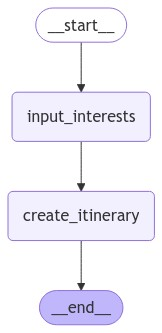

In [7]:
display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

### Define the function that runs the graph

When we compile the graph, we turn it into a LangChain Runnable, which automatically enables calling `.invoke()`, `.stream()` and `.batch()` with your inputs. In the following example, we run `stream()` to invoke the graph with inputs

In [8]:
def run_travel_planner(user_request: str, config_dict: dict):
    print(f"Current User Request: {user_request}\n")
    init_input = {"user_message": user_request,"city" : "Seattle"}

    for output in app.stream(init_input, config=config_dict, stream_mode="values"):
        pass  # The nodes themselves now handle all printing

### Travel Planner Example

- To run this the system prompts and asks for user input for activities 
- We have initialized the graph state with city Seattle which usually will be dynamic and we will see in subsequrnt labs
- You can enter like boating, swiming

In [9]:
config = {"configurable": {"thread_id": "1"}}

user_request = "Can you create a itinerary for boating, swim. Need a complete plan"
run_travel_planner(user_request, config)

Current User Request: Can you create a itinerary for boating, swim. Need a complete plan


Final Itinerary:
Okay, based on your interest in boating and swimming, here is a suggested day trip itinerary for Seattle:

Seattle Day Trip Itinerary:

Morning:
- Start your day at Fishermen's Terminal, a historic working waterfront. Rent a small boat or kayak and explore the scenic Lake Union.
- Visit the Center for Wooden Boats and learn about the region's maritime history. You can even try your hand at sailing a historic vessel.

Afternoon: 
- Head to Alki Beach, one of Seattle's best urban beaches. Spend a few hours swimming, sunbathing, and enjoying the views of the Puget Sound and the Olympic Mountains.
- Grab lunch at one of the beachfront restaurants or food trucks and soak up the laidback beach vibe.

Late Afternoon:
- Drive to Seward Park, a 300-acre peninsula jutting into Lake Washington. Hike the loop trail through the old-growth forest and visit the beach.
- Consider renting paddleb

#### Leverage the memory saver to manipulate the Graph State
- Since the `Conversation Messages` are part of the graph state we can leverage that
- However the graph state is tied to `session_id` which will be passed in as a `thread_id` which ties to a session
- If we add a request with different thread id it will create a new session which will not have the previous `Interests`
- However this this has the other check points variables as well and so this pattern is good for `A-Sync` workflow

In [10]:
config = {"configurable": {"thread_id": "1"}}

user_request = "Can you add white water rafting to this itinerary"
run_travel_planner(user_request, config)

Current User Request: Can you add white water rafting to this itinerary


Final Itinerary:
Okay, great, let's add white water rafting to the Seattle day trip itinerary:

Seattle Day Trip Itinerary:

Morning:
- Start your day at Fishermen's Terminal, a historic working waterfront. Rent a small boat or kayak and explore the scenic Lake Union.
- Visit the Center for Wooden Boats and learn about the region's maritime history. You can even try your hand at sailing a historic vessel.

Mid-Morning:
- Head out of the city to the Skykomish River, about a 1-hour drive from Seattle, for a white water rafting adventure. Join a guided rafting tour to experience the thrilling Class III-IV rapids.

Afternoon:
- Return to Seattle and head to Alki Beach, one of the city's best urban beaches. Spend a few hours swimming, sunbathing, and enjoying the views of the Puget Sound and the Olympic Mountains.
- Grab lunch at one of the beachfront restaurants or food trucks and soak up the laidback beach vibe.

La

#### Run with another session

Now this session will not have the previous conversations and we see it will create a new travel plan with the `white water rafting`  interests, not boating or swim

In [11]:
config = {"configurable": {"thread_id": "11"}}

user_request = "Can you add white water rafting to itinerary"
run_travel_planner(user_request, config)

Current User Request: Can you add white water rafting to itinerary


Final Itinerary:
Okay, got it. Based on our previous conversation and your latest request to add white water rafting, here is a suggested day trip itinerary for Seattle:

Seattle Day Trip Itinerary:

- Start your day with a visit to the iconic Pike Place Market - explore the bustling stalls, grab a fresh seafood breakfast, and watch the famous fish throwing.

- Head to the Chihuly Garden and Glass to admire the stunning glass sculptures and installations.

- Take a ride up to the observation deck of the Space Needle for panoramic views of the city skyline and Mount Rainier.

- Enjoy a white water rafting adventure on one of the nearby rivers, such as the Skykomish or Snoqualmie River, for an adrenaline-filled outdoor experience.

- After the rafting, have lunch at one of the waterfront restaurants along the Puget Sound, such as Ivar's Seafood or Elliot's Oyster House.

- Spend the afternoon exploring the exhibits at t

### Explore `External Store` for memory


For Memory we further need short term and long term memory which can be explained below. Further reading can be at this [link](https://langchain-ai.github.io/langgraph/concepts/memory/#what-is-memory)

Conversation memory can be explained by this diagram below which explains the `turn by turn` conversations which needs to be accessed by agents and then saved as a summary for long term memory

![long term memory](./images/short-vs-long.png)



#### Create an external `Memory persistence`

In this section we will leverage multi-thread, multi-session persistence to Chat Messages. Ideally you will leverage persistence like Redis Store etc to save messages per session

##### Memory Management
- We can have several Patterns - we can have each Agents with it's own Session memory
- Or we can have the whole Graph have a combined memory in which case each agent will get it's own memory

The MemorySaver or the Store have the concept of separating sections of memory by Namespaces or by Thread ID's and those can be leveraged to either 1/ Use the graph level message or memory 2/ Ecah agent can have it's own memory via space in saver or else having it's own saver like we do in the `ReACT agent`



<img src="./images/multi_memory_light.png" width="45%"/>

In [12]:
from langgraph.store.base import BaseStore, Item, Op, Result
from langgraph.store.memory import InMemoryStore
from typing import Any, Iterable, Literal, NamedTuple, Optional, Union, cast

class CustomMemoryStore(BaseStore):

    def __init__(self, ext_store):
        self.store = ext_store

    def get(self, namespace: tuple[str, ...], key: str) -> Optional[Item]:
        return self.store.get(namespace,key)

    def put(self, namespace: tuple[str, ...], key: str, value: dict[str, Any]) -> None:
        return self.store.put(namespace, key, value)
    def batch(self, ops: Iterable[Op]) -> list[Result]:
        return self.store.batch(ops)
    async def abatch(self, ops: Iterable[Op]) -> list[Result]:
        return self.store.abatch(ops)


#### Quick look at how to use this store

In [13]:
in_memory_store = CustomMemoryStore(InMemoryStore())
namespace_u = ("chat_messages", "user_id_1")
key_u="user_id_1"
in_memory_store.put(namespace_u, key_u, {"data":["list a"]})
item_u = in_memory_store.get(namespace_u, key_u)
print(item_u.value, item_u.value['data'])

in_memory_store.list_namespaces()

{'data': ['list a']} ['list a']


[('chat_messages', 'user_id_1')]

#### Create the similiar graph as earlier -- note we will not have any mesages in the Graph state as that has been externalized

In [14]:
class PlannerState(TypedDict):
    itinerary: str
    city: str
    user_message: str

In [15]:
def input_interests(state: PlannerState, config: RunnableConfig, *, store: BaseStore) -> PlannerState:
    user_message = state['user_message'] #input("Your input: ")
    return {
        **state,
    }

def create_itinerary(state: PlannerState, config: RunnableConfig, *, store: BaseStore) -> PlannerState:
    #- get the history from the store
    user_u = f"user_id_{config['configurable']['thread_id']}"
    namespace_u = ("chat_messages", user_u)
    store_item = store.get(namespace=namespace_u, key=user_u)
    chat_history_messages = store_item.value['data'] if store_item else []
    print(user_u,chat_history_messages)

    response = llm.invoke(itinerary_prompt.format_messages(city=state['city'], user_message=state['user_message'], chat_history=chat_history_messages))
    print("\nFinal Itinerary:")
    print(response.content)

    #- add back to the store
    store.put(namespace=namespace_u, key=user_u, value={"data":chat_history_messages+[HumanMessage(content=state['user_message']),AIMessage(content=response.content)]})
    
    return {
        **state,
        "itinerary": response.content
    }

In [16]:
in_memory_store_n = CustomMemoryStore(InMemoryStore())

workflow = StateGraph(PlannerState)

#workflow.add_node("input_city", input_city)
workflow.add_node("input_interests", input_interests)
workflow.add_node("create_itinerary", create_itinerary)

workflow.set_entry_point("input_interests")

#workflow.add_edge("input_city", "input_interests")
workflow.add_edge("input_interests", "create_itinerary")
workflow.add_edge("create_itinerary", END)


app = workflow.compile(store=in_memory_store_n)

In [17]:
def run_travel_planner(user_request: str, config_dict: dict):
    print(f"Current User Request: {user_request}\n")
    init_input = {"user_message": user_request,"city" : "Seattle"}

    for output in app.stream(init_input, config=config_dict, stream_mode="values"):
        pass  # The nodes themselves now handle all printing

config = {"configurable": {"thread_id": "1"}}

user_request = "Can you create a itinerary for boating, swim. Need a complete plan"
run_travel_planner(user_request, config)


Current User Request: Can you create a itinerary for boating, swim. Need a complete plan

user_id_1 []

Final Itinerary:
Okay, based on your interest in boating and swimming, here is a suggested day trip itinerary for Seattle:

Seattle Day Trip Itinerary:

Morning:
- Start your day at Fishermen's Terminal, home to the largest commercial fishing fleet on the West Coast. Explore the docks and watch the boats come and go.
- Take a scenic 1-hour cruise around the Ballard Locks and Ship Canal on the Hiram M. Chittenden Locks Cruise. Learn about the history and workings of this important waterway.

Afternoon: 
- Head to Alki Beach, a popular spot for swimming, sunbathing, and water sports. Rent a kayak, paddleboard, or other small watercraft and spend a couple hours exploring the shoreline.
- Have lunch at one of the beachfront restaurants or cafes, enjoying views of the Seattle skyline across the Puget Sound.

Late Afternoon:
- Visit Seacrest Park in West Seattle, which has a small beach, d

In [18]:
config = {"configurable": {"thread_id": "1"}}

user_request = "Can you add itinerary for white water rafting to this"
run_travel_planner(user_request, config)

Current User Request: Can you add itinerary for white water rafting to this

user_id_1 [HumanMessage(content='Can you create a itinerary for boating, swim. Need a complete plan', additional_kwargs={}, response_metadata={}), AIMessage(content="Okay, based on your interest in boating and swimming, here is a suggested day trip itinerary for Seattle:\n\nSeattle Day Trip Itinerary:\n\nMorning:\n- Start your day at Fishermen's Terminal, home to the largest commercial fishing fleet on the West Coast. Explore the docks and watch the boats come and go.\n- Take a scenic 1-hour cruise around the Ballard Locks and Ship Canal on the Hiram M. Chittenden Locks Cruise. Learn about the history and workings of this important waterway.\n\nAfternoon: \n- Head to Alki Beach, a popular spot for swimming, sunbathing, and water sports. Rent a kayak, paddleboard, or other small watercraft and spend a couple hours exploring the shoreline.\n- Have lunch at one of the beachfront restaurants or cafes, enjoying vie

#### Quick look at the store

it will show the History of the Chat Messages

In [19]:
print(in_memory_store_n.list_namespaces())
print(in_memory_store_n.get(('chat_messages', 'user_id_1'),'user_id_1').value)

[('chat_messages', 'user_id_1')]
{'data': [HumanMessage(content='Can you create a itinerary for boating, swim. Need a complete plan', additional_kwargs={}, response_metadata={}), AIMessage(content="Okay, based on your interest in boating and swimming, here is a suggested day trip itinerary for Seattle:\n\nSeattle Day Trip Itinerary:\n\nMorning:\n- Start your day at Fishermen's Terminal, home to the largest commercial fishing fleet on the West Coast. Explore the docks and watch the boats come and go.\n- Take a scenic 1-hour cruise around the Ballard Locks and Ship Canal on the Hiram M. Chittenden Locks Cruise. Learn about the history and workings of this important waterway.\n\nAfternoon: \n- Head to Alki Beach, a popular spot for swimming, sunbathing, and water sports. Rent a kayak, paddleboard, or other small watercraft and spend a couple hours exploring the shoreline.\n- Have lunch at one of the beachfront restaurants or cafes, enjoying views of the Seattle skyline across the Puget So

### Finally we review the concept of having Each `Agent` be backed by it's own memory

For this we will leverage the RunnableWithMessageHistory when creating the agent
- Here we create to simulate a InMemoryChatMessageHistory, but this will be externalized in produftion use cases
- use this this as a sample

In [20]:
from langchain_core.chat_history import InMemoryChatMessageHistory
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables.history import RunnableWithMessageHistory


# ---- ⚠️ Update region for your AWS setup ⚠️ ----
bedrock_client = boto3.client("bedrock-runtime", region_name="us-east-1")
model_id = "anthropic.claude-3-haiku-20240307-v1:0"
#model_id = "anthropic.claude-3-sonnet-20240229-v1:0"#
#model_id="anthropic.claude-3-5-sonnet-20240620-v1:0"

provider_id = "anthropic"

chatbedrock_llm = ChatBedrockConverse(
    model=model_id,
    provider=provider_id,
    temperature=0,
    max_tokens=None,
    client=bedrock_client,
    # other params...
)

itinerary_prompt = ChatPromptTemplate.from_messages([
    ("system", "You are a helpful travel assistant. Create a day trip itinerary for {city} based on the user's interests. Use the below chat conversation and the latest input from Human to get the user interests. Provide a brief, bulleted itinerary."),
    MessagesPlaceholder("chat_history"),
    ("human", "{user_message}"),
])
chain = itinerary_prompt | chatbedrock_llm 

history = InMemoryChatMessageHistory()
def get_history():
    return history

wrapped_chain = RunnableWithMessageHistory(
    chain,
    get_history,
    history_messages_key="chat_history",
)


In [21]:
class PlannerState(TypedDict):
    itinerary: str
    city: str
    user_message: str

def input_interests(state: PlannerState, config: RunnableConfig, *, store: BaseStore) -> PlannerState:
    user_message = state['user_message'] #input("Your input: ")
    return {
        **state,
    }

def create_itinerary(state: PlannerState, config: RunnableConfig, *, store: BaseStore) -> PlannerState:
    #- each agent manages it's memory
    response = wrapped_chain.invoke({"city": state['city'], "user_message": state['user_message'], "input": state['user_message']} )
    print("\nFinal Itinerary:")
    print(response.content)
    
    return {
        **state,
        "itinerary": response.content
    }

In [22]:
workflow = StateGraph(PlannerState)

#workflow.add_node("input_city", input_city)
workflow.add_node("input_interests", input_interests)
workflow.add_node("create_itinerary", create_itinerary)

workflow.set_entry_point("input_interests")

#workflow.add_edge("input_city", "input_interests")
workflow.add_edge("input_interests", "create_itinerary")
workflow.add_edge("create_itinerary", END)


app = workflow.compile()

In [23]:
def run_travel_planner(user_request: str, config_dict: dict):
    print(f"Current User Request: {user_request}\n")
    init_input = {"user_message": user_request,"city" : "Seattle"}

    for output in app.stream(init_input, config=config_dict, stream_mode="values"):
        pass  # The nodes themselves now handle all printing

config = {"configurable": {"thread_id": "1"}}

user_request = "Can you create a itinerary for boating, swim. Need a complete plan"
run_travel_planner(user_request, config)

Current User Request: Can you create a itinerary for boating, swim. Need a complete plan


Final Itinerary:
Okay, based on your interest in boating and swimming, here is a suggested day trip itinerary for Seattle:

Seattle Day Trip Itinerary:

Morning:
- Start your day at Fishermen's Terminal, a historic working waterfront. Rent a small boat or kayak and explore the scenic Lake Union.
- Visit the Center for Wooden Boats and learn about the region's maritime history. You can even try your hand at sailing a historic vessel.

Afternoon: 
- Head to Alki Beach, one of Seattle's best urban beaches. Spend a few hours swimming, sunbathing, and enjoying the views of the Puget Sound and the Olympic Mountains.
- Have lunch at one of the beachfront restaurants or food trucks, enjoying fresh seafood and local cuisine.

Late Afternoon:
- Visit Seacrest Park in West Seattle, which has a public swimming pool, beach access, and a fishing pier. Spend time swimming, relaxing, and taking in the views.
- C

In [24]:
user_request = "Can you add white water rafting to this itinerary"
run_travel_planner(user_request, config)

Current User Request: Can you add white water rafting to this itinerary


Final Itinerary:
Okay, great, let's add white water rafting to the Seattle day trip itinerary:

Seattle Day Trip Itinerary:

Morning:
- Start your day at Fishermen's Terminal, a historic working waterfront. Rent a small boat or kayak and explore the scenic Lake Union.
- Visit the Center for Wooden Boats and learn about the region's maritime history. You can even try your hand at sailing a historic vessel.

Mid-Morning:
- Head out of the city to the Skykomish River, about 1 hour east of Seattle, for a white water rafting adventure. Spend 2-3 hours rafting down the river's exciting Class III-IV rapids.

Afternoon:
- Head to Alki Beach, one of Seattle's best urban beaches. Spend a few hours swimming, sunbathing, and enjoying the views of the Puget Sound and the Olympic Mountains. 
- Have lunch at one of the beachfront restaurants or food trucks, enjoying fresh seafood and local cuisine.

Late Afternoon:
- Visit Seac

#### Let us examine a `ReACT` agent with external memory

langGraph executor is 

    - invoke with "messages" as  the query or you could pass in the chat history with the latest user message
    - returns a message list variable and [-1] of that is the answer from the agents
    - messages = langgraph_agent_executor.invoke({"messages": [("human", query)]})

LangGraph's prebuilt create_react_agent does not take a prompt template directly as a parameter, but instead takes a state_modifier parameter. This modifies the graph state before the llm is called, and can be one of four values:

    - A SystemMessage, which is added to the beginning of the list of messages.
    - A string, which is converted to a SystemMessage and added to the beginning of the list of messages.
    - A Callable, which should take in full graph state. The output is then passed to the language model.
    - Or a Runnable, which should take in full graph state. The output is then passed to the language model.

Memory is just checkpointing -- you could use the external store

    - Add a checkpointer to the agent and you get chat memory for free.

In [25]:
from langchain.tools import tool
from langgraph.prebuilt import create_react_agent
from langgraph.prebuilt.chat_agent_executor import AgentState

# ---- ⚠️ Update region for your AWS setup ⚠️ ----
bedrock_client = boto3.client("bedrock-runtime", region_name="us-east-1")
model_id = "anthropic.claude-3-haiku-20240307-v1:0"
#model_id = "anthropic.claude-3-sonnet-20240229-v1:0"#
#model_id="anthropic.claude-3-5-sonnet-20240620-v1:0"

provider_id = "anthropic"

llm = ChatBedrockConverse(
    model=model_id,
    provider=provider_id,
    temperature=0,
    max_tokens=None,
    client=bedrock_client,
    # other params...
)
@tool ("book_appointment")
def book_appointment(date: str, time:str) -> dict:
    """Use this function to book an appointment. This function needs date and time as a string to books the appointment with the travel agent. This function returns the booking id back which you must send to the user"""

    print(date, time)
    return {"status" : True, "date": date, "booking_id": "id_123"}

@tool ("create_travel_plan")
def create_travel_plan( city: str, interest: str) -> dict:
    """Call to create a complete itinerary for the user. Input is the city and comman separated interests """
    print(f"Travel tool {city} :: called with {interest}")
    interest_list = interest.split(",")
    return_message = f"Here is a complete itinerary and travel plan. You can do many things in {city} like {interest}."
    for one in interest_list:
        return_message += f" For {one}: you should go to Pier_{one}:: and do the activity {one}."
    
    return {"travel_plan": return_message+".That completes the itinerary."}


tool_list_str = [ "book_appointment", "create_travel_plan" ]
tools_list = [book_appointment,create_travel_plan ]

itinerary_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", "You are a helpful assistant to create travel itinerary for city {city} based on the user interests. You can use tools as needed. Only call the tool once"),
        ("placeholder", "{messages}"),
    ]
)

def callable_modify_state_messages(state: AgentState):
    #print(f"\nstate={state}::")
    input_to_model = itinerary_prompt.invoke({ "city": "Seattle", }).to_messages() + state['messages']
    #print(input_to_model)
    return input_to_model


from langgraph.prebuilt import create_react_agent
memory = MemorySaver()
langgraph_agent_executor = create_react_agent(llm, tools_list,  checkpointer=memory, state_modifier=callable_modify_state_messages)

#display(Image(langgraph_agent_executor.get_graph().draw_mermaid_png()))

config = {"configurable": {"thread_id": "test-thread-1",}, "recursion_limit": 6, 'stream_mode':"updates"}
response_agent = langgraph_agent_executor.invoke(
    input={"messages": [HumanMessage(content="Can you create a itinerary for interests boating, swiming only for the city of Seattle. Need a complete plan, do not summarize")]},
    config=config
)

print(
    {
        "input": response_agent["messages"][0].content,#query,
        "output": response_agent["messages"][-1].content,
    }
)


Travel tool Seattle :: called with boating, swimming
{'input': 'Can you create a itinerary for interests boating, swiming only for the city of Seattle. Need a complete plan, do not summarize', 'output': 'The complete travel plan for Seattle with the interests of boating and swimming is:\n\nFor boating:\n- Go to Pier_boating:: and do the activity boating.\n\nFor swimming: \n- Go to Pier_swimming:: and do the activity swimming.\n\nThis covers the key activities related to the interests of boating and swimming in Seattle. Let me know if you need any clarification or have additional requests!'}


##### To view the `Chat_history` just print the full response

- we will now add to the conversation as say add white water rafting and we will see it will add that to the itinerary

In [26]:
#llm.bind_tools(tools_list).invoke("can you create itenary for me for boat in Seattle?")
response_agent

{'messages': [HumanMessage(content='Can you create a itinerary for interests boating, swiming only for the city of Seattle. Need a complete plan, do not summarize', additional_kwargs={}, response_metadata={}, id='f55aa4c4-5013-4bf5-8329-2458b06b6e01'),
  AIMessage(content=[{'type': 'text', 'text': "Okay, let's create a travel plan for Seattle with the interests of boating and swimming."}, {'type': 'tool_use', 'name': 'create_travel_plan', 'input': {'city': 'Seattle', 'interest': 'boating, swimming'}, 'id': 'tooluse_PuDueoJySjaG1QcjQqHvtg'}], additional_kwargs={}, response_metadata={'ResponseMetadata': {'RequestId': '7a918db0-a6ec-48ed-a8d3-f60c97e422a6', 'HTTPStatusCode': 200, 'HTTPHeaders': {'date': 'Mon, 11 Nov 2024 18:05:37 GMT', 'content-type': 'application/json', 'content-length': '417', 'connection': 'keep-alive', 'x-amzn-requestid': '7a918db0-a6ec-48ed-a8d3-f60c97e422a6'}, 'RetryAttempts': 0}, 'stopReason': 'tool_use', 'metrics': {'latencyMs': 1226}}, id='run-e4af0006-0c79-41ef-

In [27]:
response_agent = langgraph_agent_executor.invoke(
    input={"messages": [HumanMessage(content="can you white water rafting to this itinerary")]},
    config=config
)

print(
    {
        "input": response_agent["messages"][0].content,#query,
        "output": response_agent["messages"][-1].content,
    }
)


Travel tool Seattle :: called with boating, swimming, white water rafting
{'input': 'Can you create a itinerary for interests boating, swiming only for the city of Seattle. Need a complete plan, do not summarize', 'output': 'The complete travel plan for Seattle with the interests of boating, swimming, and white water rafting is:\n\nFor boating:\n- Go to Pier_boating:: and do the activity boating.\n\nFor swimming:\n- Go to Pier_swimming:: and do the activity swimming. \n\nFor white water rafting:\n- Go to Pier_white water rafting:: and do the activity white water rafting.\n\nThis covers the key activities related to the interests of boating, swimming, and white water rafting in Seattle. Let me know if you need any other additions to the itinerary.'}


In [28]:
response_agent

{'messages': [HumanMessage(content='Can you create a itinerary for interests boating, swiming only for the city of Seattle. Need a complete plan, do not summarize', additional_kwargs={}, response_metadata={}, id='f55aa4c4-5013-4bf5-8329-2458b06b6e01'),
  AIMessage(content=[{'type': 'text', 'text': "Okay, let's create a travel plan for Seattle with the interests of boating and swimming."}, {'type': 'tool_use', 'name': 'create_travel_plan', 'input': {'city': 'Seattle', 'interest': 'boating, swimming'}, 'id': 'tooluse_PuDueoJySjaG1QcjQqHvtg'}], additional_kwargs={}, response_metadata={'ResponseMetadata': {'RequestId': '7a918db0-a6ec-48ed-a8d3-f60c97e422a6', 'HTTPStatusCode': 200, 'HTTPHeaders': {'date': 'Mon, 11 Nov 2024 18:05:37 GMT', 'content-type': 'application/json', 'content-length': '417', 'connection': 'keep-alive', 'x-amzn-requestid': '7a918db0-a6ec-48ed-a8d3-f60c97e422a6'}, 'RetryAttempts': 0}, 'stopReason': 'tool_use', 'metrics': {'latencyMs': 1226}}, id='run-e4af0006-0c79-41ef-

In [ ]:
class PlannerState(TypedDict):
    itinerary: str
    city: str
    user_message: str

In [ ]:
def input_interests(state: PlannerState, config: RunnableConfig, *, store: BaseStore) -> PlannerState:
    user_message = state['user_message'] #input("Your input: ")
    return {
        **state,
    }

def create_itinerary(state: PlannerState, config: RunnableConfig, *, store: BaseStore) -> PlannerState:
    #- get the history from the store
    user_u = f"user_id_{config['configurable']['thread_id']}"
    namespace_u = ("chat_messages", user_u)
    store_item = store.get(namespace=namespace_u, key=user_u)
    chat_history_messages = store_item.value['data'] if store_item else []
    print(user_u,chat_history_messages)

    response = llm.invoke(itinerary_prompt.format_messages(city=state['city'], user_message=state['user_message'], chat_history=chat_history_messages))
    print("\nFinal Itinerary:")
    print(response.content)

    #- add back to the store
    store.put(namespace=namespace_u, key=user_u, value={"data":chat_history_messages+[HumanMessage(content=state['user_message']),AIMessage(content=response.content)]})
    
    return {
        **state,
        "itinerary": response.content
    }

In [ ]:
in_memory_store_n = CustomMemoryStore(InMemoryStore())

workflow = StateGraph(PlannerState)

#workflow.add_node("input_city", input_city)
workflow.add_node("input_interests", input_interests)
workflow.add_node("create_itinerary", create_itinerary)

workflow.set_entry_point("input_interests")

#workflow.add_edge("input_city", "input_interests")
workflow.add_edge("input_interests", "create_itinerary")
workflow.add_edge("create_itinerary", END)


app = workflow.compile(store=in_memory_store_n)

In [ ]:
def run_travel_planner(user_request: str, config_dict: dict):
    print(f"Current User Request: {user_request}\n")
    init_input = {"user_message": user_request,"city" : "Seattle"}

    for output in app.stream(init_input, config=config_dict, stream_mode="values"):
        pass  # The nodes themselves now handle all printing

config = {"configurable": {"thread_id": "1"}}

user_request = "Can you create a itinerary for boating, swim. Need a complete plan"
run_travel_planner(user_request, config)

## Conclusion

You have successfully executed a simple LangGraph implementation, this lab demonstrates how LangGraph can be used to create a simple yet effective Travel Planner. By structuring our application as a graph of interconnected nodes, we achieve a clear separation of concerns and a easily modifiable workflow. This approach can be extended to more complex applications, showcasing the power and flexibility of graph-based designs in AI-driven conversational interfaces.

Please proceed to the next lab

In [ ]:
ToolNode
